# Challenge: Evaluate Sentiment Classifier

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from scipy.stats import ttest_ind

%matplotlib inline

In this assignment, I am going to use a dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). Specifically, it is a sentiment analysis dataset taken from 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015. The dataset consists of four different company data files. I will use the Amazon data file for this analysis.

## Helper Functions
In this section, I will define functions I will use during the data cleaning, feature engineering, and modeling phases.

In [2]:
# Data cleaning
punctuation = ['!', '(', ')', '/', ';', ':', ',', '?', '.']
common_words = ['the', 'and', 'i', 'is', 'it', 'a', 'this', 'to', 'my', 'for', 'with', 'of', 'on', 'have', 'was',
               'in', 'that', 'so', 'has', 'and', 'are', 'but', 'had', 'use', 'you', 'as', 'all', 'if', 'me', 'after',
               'your', 'would', 'from', 'than', "i\'ve", "it\'s", 'any', 'be', 'then', 'when', 'at', 'or']

In [3]:
# Data cleaning
def clean_sentences(df, remove_common_words=True):
    
    dirty_sentences = df.loc[:, 'sentence'].values
    
    # Remove punctuation
    clean_sentences = dirty_sentences
    for mark in punctuation:
        clean_sentences = [x.replace(mark, '') for x in clean_sentences]
    
    unique_words_list = []
    i = 0
    for sentence in clean_sentences:
        split_sentence = sentence.split(' ')
        
        # Convert words to lower case
        clean_split_sentence = [x.strip().lower() for x in split_sentence]
        
        # Only save unique words
        unique_words = list(set(clean_split_sentence))
        
        # Remove common words
        if remove_common_words:
            for word in common_words:
                if word in unique_words:
                    unique_words.remove(word)
                
        unique_words_string = ' '.join(unique_words)
        unique_words_list.append(unique_words_string)
        
    df['unique_words'] = unique_words_list
    
    return df.copy()

In [4]:
# Feature engineering
def average_word_length(df):
    
    dirty_sentences = df.loc[:, 'sentence'].values
    
    # Remove punctuation
    clean_sentences = dirty_sentences
    for mark in punctuation:
        clean_sentences = [x.replace(mark, '') for x in clean_sentences]
    
    unique_words_list = []
    i = 0
    for sentence in clean_sentences:
        split_sentence = sentence.split(' ')
        
        # Convert words to lower case
        clean_split_sentence = [x.strip().lower() for x in split_sentence]
        
        # Only save unique words
        unique_words = list(set(clean_split_sentence))
        
        # Remove common words
        if remove_common_words:
            for word in common_words:
                if word in unique_words:
                    unique_words.remove(word)
                
        unique_words_string = ' '.join(unique_words)
        unique_words_list.append(unique_words_string)
        
    df['unique_words'] = unique_words_list
    
    return df.copy()

In [5]:
# Feature engineering
def add_positive_words(df, positive_words):
    for word in positive_words:
        df[word] = df['unique_words'].str.contains(f' {word} ', case=False)
    return df

In [6]:
# Modeling
def run_model(df, model, positive_words):
    # Define feature and target variables
    X = df.loc[:, positive_words]
    y = df['label']
    
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    hold_out_score = bnb.fit(X_train, y_train).score(X_test, y_test)
    print(f'Hold out score: {hold_out_score}')
    
    # Prediction
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    confusion_matrix = pd.crosstab(y_test, y_pred, 
                                   rownames=['Actual'], colnames=['Predicted'])
    print(f'Confusion Matrix:\n{confusion_matrix}')
    
    # Perform five-fold cross validation
    cv_scores = cross_val_score(model, X, y, cv=10)
    print(f'Cross-validation scores: {cv_scores.tolist()}')

In [7]:
# Modeling
def print_tstats(df, column):
    positive = df.loc[df['label'] == 1, column].values
    negative = df.loc[df['label'] == 0, column].values
    tstat, pvalue = ttest_ind(positive, negative)
    print(f'T-statistics for {column}:')
    print(f'\tt-statistic={tstat}, pvalue = {pvalue}')

## Data Exploration
### Load data

In [8]:
data_file = 'amazon_cells_labelled.txt'
df = pd.read_csv(f'./data/{data_file}', delimiter='\t', header=None)
df.columns = ['sentence', 'label']

In [9]:
df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [10]:
print(f'The fraction of positive labels is {df["label"].sum() / len(df)}.')

The fraction of positive labels is 0.5.


## Model 1
### Data Cleaning
Clean the sentences.
1. Remove punctuation.
2. Convert all words to lower case.

In [11]:
df_clean_m1 = clean_sentences(df, remove_common_words=False)

In [12]:
df_clean_m1.head()

,sentence,label,unique_words
0,So there is no way for me to plug it in here i...,0,it go a there so no me by to unless the here f...
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great the for jawbone
3,Tied to charger for conversations lasting more...,0,problems conversations more 45 to tied than fo...
4,The mic is great.,1,mic great the is


### Feature Engineering
#### Select keywords

In [13]:
positive_list_m1 = ' '.join(df_clean_m1.loc[df['label'] == 1, 'unique_words'].values.tolist()).split(' ')

In [14]:
pd.Series(positive_list_m1).value_counts()[:25]

the        176
and        165
i          139
is         121
it         110
this       105
a           90
great       90
phone       82
to          77
very        68
with        61
for         59
good        59
my          57
works       45
of          45
on          42
have        35
in          34
product     33
was         33
well        31
quality     31
that        30
dtype: int64

In [15]:
positive_words_m1 = pd.Series(positive_list_m1).value_counts().index.tolist()[:10]
print(positive_words_m1)

['the', 'and', 'i', 'is', 'it', 'this', 'a', 'great', 'phone', 'to']


#### Add features
Add positive words as additional columns to the cleaned dataset.

In [16]:
df_clean_m1 = add_positive_words(df_clean_m1, positive_words_m1)

In [17]:
df_clean_m1.head()

,sentence,label,unique_words,the,and,i,is,it,this,a,great,phone,to
0,So there is no way for me to plug it in here i...,0,it go a there so no me by to unless the here f...,True,False,True,False,False,False,True,False,False,True
1,"Good case, Excellent value.",1,good case excellent value,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,great the for jawbone,True,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,problems conversations more 45 to tied than fo...,False,False,False,False,False,False,False,False,False,True
4,The mic is great.,1,mic great the is,True,False,False,False,False,False,False,True,False,False


#### Feature correlations
Inspect the correlations between the postive word features.

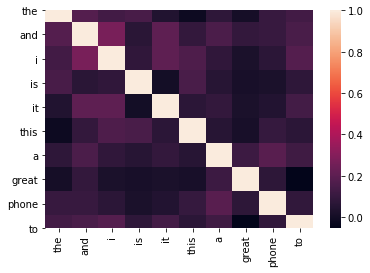

In [18]:
sns.heatmap(df_clean_m1.loc[:, positive_words_m1].corr())
plt.show()

**Observation:** Most of the correlations are pretty low.

### Modeling

In [19]:
# Instantiate the model
bnb = BernoulliNB()

In [20]:
run_model(df_clean_m1, bnb, positive_words_m1)

Hold out score: 0.595
Confusion Matrix:
Predicted   0   1
Actual           
0          70  23
1          58  49
Cross-validation scores: [0.6, 0.58, 0.57, 0.56, 0.54, 0.55, 0.61, 0.6, 0.55, 0.62]


## Model 2
### Data Cleaning
Clean the sentences.
1. Remove punctuation.
2. Convert all words to lower case.
3. Remove common words.

In [21]:
df_clean_m2 = clean_sentences(df)

In [22]:
df_clean_m2.head()

,sentence,label,unique_words
0,So there is no way for me to plug it in here i...,0,go there no by unless here plug way us converter
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great jawbone
3,Tied to charger for conversations lasting more...,0,problems conversations more 45 tied minutesmaj...
4,The mic is great.,1,mic great


### Feature Engineering
#### Select keywords

In [23]:
positive_list_m2 = ' '.join(df_clean_m2.loc[df['label'] == 1, 'unique_words'].values.tolist()).split(' ')

In [24]:
pd.Series(positive_list_m2).value_counts()[:25]

great        90
phone        82
very         68
good         59
works        45
product      33
quality      31
well         31
headset      29
excellent    26
price        25
sound        24
nice         22
one          22
battery      21
love         20
best         20
recommend    20
case         18
like         18
really       15
ear          14
not          14
easy         14
happy        13
dtype: int64

In [25]:
positive_words_m2 = ['great', 'very', 'good', 'works', 'quality', 'well', 'excellent', 'nice', 'love', 'best']
print(positive_words_m2)

['great', 'very', 'good', 'works', 'quality', 'well', 'excellent', 'nice', 'love', 'best']


#### Add features
Add positive words as additional columns to the cleaned dataset.

In [26]:
df_clean_m2 = add_positive_words(df_clean_m2, positive_words_m2)

In [27]:
df_clean_m2.head()

,sentence,label,unique_words,great,very,good,works,quality,well,excellent,nice,love,best
0,So there is no way for me to plug it in here i...,0,go there no by unless here plug way us converter,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,good case excellent value,False,False,False,False,False,False,True,False,False,False
2,Great for the jawbone.,1,great jawbone,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,problems conversations more 45 tied minutesmaj...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,mic great,False,False,False,False,False,False,False,False,False,False


#### Feature correlations
Inspect the correlations between the postive word features.

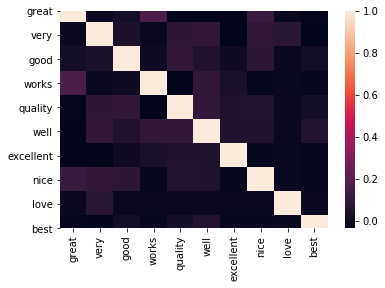

In [28]:
sns.heatmap(df_clean_m2.loc[:, positive_words_m2].corr())
plt.show()

**Observation:** After removing the common words, the features are much less correlated.

### Modeling

In [29]:
# Instantiate the model
bnb = BernoulliNB()

In [30]:
run_model(df_clean_m2, bnb, positive_words_m2)

Hold out score: 0.61
Confusion Matrix:
Predicted   0   1
Actual           
0          84   9
1          69  38
Cross-validation scores: [0.68, 0.63, 0.67, 0.63, 0.67, 0.66, 0.61, 0.63, 0.65, 0.54]


## Model 3
1. Remove punctuation.
2. Convert all words to lower case.
3. Remove common words.
4. No overlap with negative words.

### Data Cleaning
Clean the sentences.

In [31]:
df_clean_m3 = clean_sentences(df)

In [32]:
df_clean_m3.head()

,sentence,label,unique_words
0,So there is no way for me to plug it in here i...,0,go there no by unless here plug way us converter
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great jawbone
3,Tied to charger for conversations lasting more...,0,problems conversations more 45 tied minutesmaj...
4,The mic is great.,1,mic great


### Feature Engineering
#### Select keywords

In [33]:
positive_list_m3 = ' '.join(df_clean_m3.loc[df['label'] == 1, 'unique_words'].values.tolist()).split(' ')

In [34]:
pd.Series(positive_list_m3).value_counts()[:25]

great        90
phone        82
very         68
good         59
works        45
product      33
quality      31
well         31
headset      29
excellent    26
price        25
sound        24
nice         22
one          22
battery      21
love         20
best         20
recommend    20
case         18
like         18
really       15
ear          14
not          14
easy         14
happy        13
dtype: int64

In [35]:
negative_list = ' '.join(df_clean_m3.loc[df['label'] == 0, 'unique_words'].values.tolist()).split(' ')

In [36]:
pd.Series(negative_list).value_counts()[:25]

not        97
phone      73
very       30
work       25
battery    23
product    22
don't      21
money      18
does       18
quality    18
ear        17
only       17
time       16
headset    16
out        16
first      15
one        15
service    15
poor       14
doesn't    14
bad        14
do         14
waste      14
buy        14
sound      14
dtype: int64

In [37]:
positive_words_m3 = ['great', 'good', 'well', 'excellent', 'nice', 'love', 'best', 'recommend', 'like', 'easy']
print(positive_words_m3)

['great', 'good', 'well', 'excellent', 'nice', 'love', 'best', 'recommend', 'like', 'easy']


#### Add features
Add positive words as additional columns to the cleaned dataset.

In [38]:
df_clean_m3 = add_positive_words(df_clean_m3, positive_words_m3)

In [39]:
df_clean_m3.head()

,sentence,label,unique_words,great,good,well,excellent,nice,love,best,recommend,like,easy
0,So there is no way for me to plug it in here i...,0,go there no by unless here plug way us converter,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,good case excellent value,False,False,False,True,False,False,False,False,False,False
2,Great for the jawbone.,1,great jawbone,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,problems conversations more 45 tied minutesmaj...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,mic great,False,False,False,False,False,False,False,False,False,False


#### Feature correlations
Inspect the correlations between the postive word features.

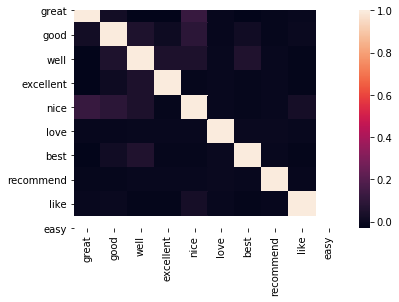

In [40]:
sns.heatmap(df_clean_m3.loc[:, positive_words_m3].corr())
plt.show()

### Modeling

In [41]:
# Instantiate the model
bnb = BernoulliNB()

In [42]:
run_model(df_clean_m3, bnb, positive_words_m3)

Hold out score: 0.57
Confusion Matrix:
Predicted   0   1
Actual           
0          87   6
1          80  27
Cross-validation scores: [0.62, 0.64, 0.6, 0.64, 0.61, 0.61, 0.6, 0.55, 0.64, 0.55]


## Model 4
1. Remove punctuation.
2. Convert all words to lower case.
3. Remove common words.
4. No overlap with negative words.
5. Five positive words instead of 10

### Data Cleaning
Clean the sentences.

In [43]:
df_clean_m4 = clean_sentences(df)

### Feature Engineering
#### Select keywords

In [44]:
positive_list_m4 = ' '.join(df_clean_m4.loc[df['label'] == 1, 'unique_words'].values.tolist()).split(' ')

In [45]:
positive_words_m4 = ['great', 'good', 'well', 'excellent', 'nice']
print(positive_words_m4)

['great', 'good', 'well', 'excellent', 'nice']


#### Add features
Add positive words as additional columns to the cleaned dataset.

In [46]:
df_clean_m4 = add_positive_words(df_clean_m4, positive_words_m4)

#### Feature correlations
Inspect the correlations between the postive word features.

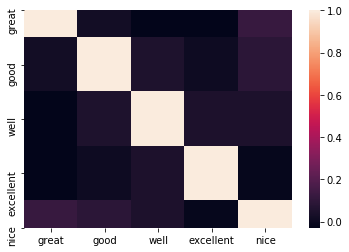

In [47]:
sns.heatmap(df_clean_m4.loc[:, positive_words_m4].corr())
plt.show()

### Modeling

In [48]:
# Instantiate the model
bnb = BernoulliNB()

In [49]:
run_model(df_clean_m4, bnb, positive_words_m4)

Hold out score: 0.56
Confusion Matrix:
Predicted   0   1
Actual           
0          89   4
1          84  23
Cross-validation scores: [0.6, 0.64, 0.57, 0.63, 0.59, 0.61, 0.58, 0.54, 0.62, 0.53]


## Model 5
* 5 positive words.
* No overlap with negative words. 
* Remove common words.
* Create new feature: 
    * Review length.
    * Average word length.

In [50]:
df_clean_m5 = clean_sentences(df)

### Feature Engineering
#### Select keywords

In [51]:
positive_list_m5 = ' '.join(df_clean_m5.loc[df['label'] == 1, 'unique_words'].values.tolist()).split(' ')

In [52]:
positive_words_m5 = ['great', 'good', 'well', 'excellent', 'nice']
print(positive_words_m5)

['great', 'good', 'well', 'excellent', 'nice']


In [53]:
df_clean_m5['review_length'] = df_clean_m5['sentence'].apply(lambda x: len(x))

# Standardize
mean_review_length = df_clean_m5['review_length'].mean()
std_review_length = df_clean_m5['review_length'].std()
df_clean_m5['review_length_standard'] = (df_clean_m5['review_length'] - mean_review_length) / std_review_length

In [54]:
df_clean_m5['avg_word_length'] = df_clean_m5['unique_words'].apply(lambda x: np.mean([len(y) for y in x.split(' ')]))

# Standardize
mean_avg_word_length = df_clean_m5['avg_word_length'].mean()
std_avg_word_length = df_clean_m5['avg_word_length'].std()
df_clean_m5['avg_word_length_standard'] = (df_clean_m5['avg_word_length'] - mean_avg_word_length) / std_avg_word_length



In [55]:
df_clean_m5.loc[df_clean_m5['label'] == 0, :].describe().T

,count,mean,std,min,25%,50%,75%,max
label,500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
review_length,500.0,56.824000,34.022464,11.000000,29.000000,52.000000,77.000000,149.000000
review_length_standard,500.0,0.046114,0.981791,-1.276235,-0.756807,-0.093093,0.628335,2.706048
avg_word_length,500.0,5.585668,1.377346,3.000000,4.714286,5.316667,6.142857,14.000000
avg_word_length_standard,500.0,0.003215,1.101128,-2.063913,-0.693417,-0.211839,0.448663,6.730104


In [56]:
df_clean_m5.loc[df_clean_m5['label'] == 1, :].describe().T

,count,mean,std,min,25%,50%,75%,max
label,500.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
review_length,500.0,53.628000,35.234764,11.000000,25.000000,43.000000,78.000000,148.000000
review_length_standard,500.0,-0.046114,1.016774,-1.276235,-0.872236,-0.352807,0.657192,2.677191
avg_word_length,500.0,5.577624,1.111429,3.000000,4.893750,5.433333,6.111111,10.000000
avg_word_length_standard,500.0,-0.003215,0.888539,-2.063913,-0.549943,-0.118570,0.423284,3.532280


In [57]:
print_tstats(df_clean_m5, 'review_length_standard')

T-statistics for review_length_standard:
	t-statistic=-1.459066679435652, pvalue = 0.1448614137236777


In [58]:
print_tstats(df_clean_m5, 'avg_word_length_standard')

T-statistics for avg_word_length_standard:
	t-statistic=-0.10162925113622785, pvalue = 0.9190713748432151


#### Add features
Add positive words as additional columns to the cleaned dataset. Also, include _review_length_ and _avg_word_length_.

In [59]:
df_clean_m5 = add_positive_words(df_clean_m5, positive_words_m5)

#### Feature correlations
Inspect the correlations between the postive word features.

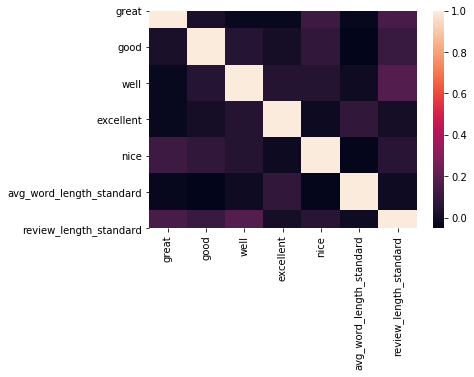

In [60]:
sns.heatmap(df_clean_m5.loc[:, positive_words_m5 + ['avg_word_length_standard', 'review_length_standard']].corr())
plt.show()

### Modeling

In [61]:
# Instantiate the model
bnb = BernoulliNB()

In [62]:
run_model(df_clean_m5, bnb, positive_words_m5 + ['avg_word_length_standard', 'review_length_standard'])

Hold out score: 0.56
Confusion Matrix:
Predicted   0   1
Actual           
0          89   4
1          84  23
Cross-validation scores: [0.6, 0.64, 0.57, 0.63, 0.59, 0.56, 0.58, 0.54, 0.62, 0.53]


## Conclusions
None of the models seem to perform well. All of them have low accuracy. Also, there is a large number of false negatives (predicted value is 0, but actual value is 1).